In [252]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [415]:
import os
import pickle
from collections import namedtuple

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

from Corpora import MovieReviewCorpus
from Lexicon import SentimentLexicon
from Statistics import SignTest
from Classifiers import NaiveBayesText, SVMText
from Extensions import SVMDoc2Vec
from Constants import PUNCTUATION

In [355]:
plt.rc('font', size=20) 

In [254]:
# whether to use corpus pickles
use_pickles = True

In [255]:
plot_dir = 'plots'

# Load Corpus

In [256]:
# retrieve corpus
corpus_pickle = "corpus.pkl"
if use_pickles and os.path.isfile(corpus_pickle):
    with open(corpus_pickle, 'rb') as f:
        corpus = pickle.load(f)
else:
    corpus=MovieReviewCorpus(stemming=False)
    with open(corpus_pickle, 'wb') as f:
        pickle.dump(corpus, f)

# Sign Test

In [257]:
# use sign test for all significance testing
signTest=SignTest()

# Sentiment Lexicon

In [258]:
print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

--- classifying reviews using sentiment lexicon  ---


## Question 0.1

In [259]:
# on average there are more positive than negative words per review (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself) to make it harder to classify as positive
threshold=8

lexicon.classify(corpus.reviews,threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
token_preds=lexicon.predictions
print(f"token-only results: {lexicon.getAccuracy():.5f}")

lexicon.classify(corpus.reviews,threshold,magnitude=True,weak_polarity=1,strong_polarity=2)
magnitude_preds=lexicon.predictions
print(f"magnitude results: {lexicon.getAccuracy():.5f}")

token-only results: 0.67900
magnitude results: 0.68250


In [260]:
lexicon_df = pd.DataFrame(lexicon.lexicon).T.reset_index().rename(columns={'index': 'word', 0: 'magnitude', 1: 'polarity'})
lexicon_df

,word,magnitude,polarity
0,abandoned,weaksubj,negative
1,abandonment,weaksubj,negative
2,abandon,weaksubj,negative
3,abase,strongsubj,negative
4,abasement,strongsubj,negative
...,...,...,...
6881,zealot,strongsubj,negative
6882,zealous,strongsubj,negative
6883,zealously,strongsubj,negative
6884,zenith,strongsubj,positive


### Grid Searches

#### Polarity

In [261]:
lexicon_thresholds = np.arange(-20,20)
lexicon_pol_gs_df = pd.DataFrame(lexicon_thresholds, columns=['threshold'])
def lexicon_pol_gs_func(x):
    lexicon.classify(corpus.reviews,x.threshold,magnitude=False,weak_polarity=1,strong_polarity=1)
    return lexicon.getAccuracy()
lexicon_pol_gs_df['result'] = lexicon_pol_gs_df.apply(lexicon_pol_gs_func,axis=1)

In [262]:
lexicon_pol_gs_df.sort_values('result', ascending=False).head(3)

,threshold,result
31,11,0.6790
28,8,0.6790
30,10,0.6785


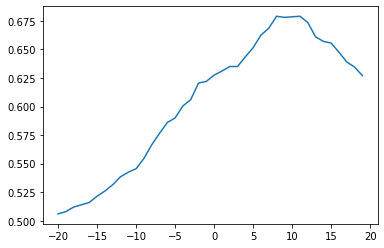

In [263]:
plt.plot(lexicon_pol_gs_df.threshold, lexicon_pol_gs_df.result)

#### Magnitude

In [264]:
lexicon_thresholds = np.arange(20)
lexicon_polarities = np.array(
    [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [2, 5], [3 ,5]]
)
lexicon_mag_gs_df = pd.DataFrame(lexicon_thresholds, columns=['threshold']).merge(pd.DataFrame(lexicon_polarities, columns=['weak_polarity', 'strong_polarity']), how='cross')
def lexicon_mag_gs_func(x):
    lexicon.classify(corpus.reviews,x.threshold,magnitude=True,weak_polarity=x.weak_polarity,strong_polarity=x.strong_polarity)
    return lexicon.getAccuracy()
lexicon_mag_gs_df['result'] = lexicon_mag_gs_df.apply(lexicon_mag_gs_func,axis=1)

In [265]:
lexicon_mag_gs_df.sort_values('result', ascending=False).head(10)

,threshold,weak_polarity,strong_polarity,result
99,14,1,2,0.6970
135,19,1,3,0.6965
114,16,1,3,0.6960
85,12,1,2,0.6960
92,13,1,2,0.6955
130,18,1,5,0.6950
100,14,1,3,0.6945
107,15,1,3,0.6945
123,17,1,5,0.6945
93,13,1,3,0.6945


In [266]:
lexicon_mag_gs_df.loc[(lexicon_mag_gs_df.threshold == 8) & (lexicon_mag_gs_df.weak_polarity == 2) & (lexicon_mag_gs_df.strong_polarity == 5)]

,threshold,weak_polarity,strong_polarity,result
61,8,2,5,0.6685


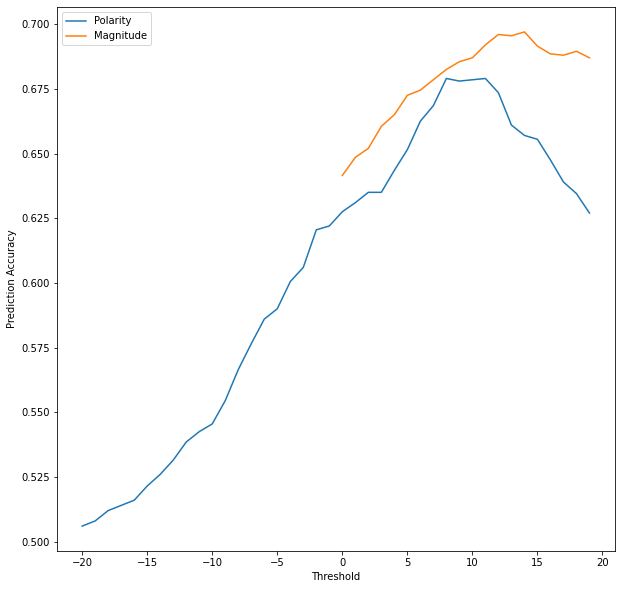

In [267]:
lexicon_mag_gs_1_2_df = lexicon_mag_gs_df.loc[(lexicon_mag_gs_df.weak_polarity == 1) & (lexicon_mag_gs_df.strong_polarity == 2)]

fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(lexicon_pol_gs_df.threshold, lexicon_pol_gs_df.result, label='Polarity')
ax.plot(lexicon_mag_gs_1_2_df.threshold, lexicon_mag_gs_1_2_df.result, label='Magnitude')
ax.set_xlabel('Threshold')
ax.set_ylabel('Prediction Accuracy')
ax.legend()
fig.savefig(os.path.join(plot_dir, 'lexicon_thresholds.jpeg'), pad_inches=0.2, bbox_inches='tight')

## Question 0.2

In [314]:
p_value=signTest.getSignificance(token_preds,magnitude_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"magnitude lexicon results are {significance} with respect to token-only")

magnitude lexicon results are not significant with respect to token-only


# Naive Bayes

## Question 1.0

In [387]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [386]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus)
# store predictions from classifier
nb_non_smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47000
Std. Dev: 0.07810


### Document and Word Probabilities

In [398]:
NB.prior

{'POS': 0.5, 'NEG': 0.5}

In [330]:
nb_word_freq = pd.DataFrame(NB.condProb).reset_index().rename(columns={'level_0': 'word'})
nb_word_freq

,word,POS,NEG
0,norway,0.000003,0.000003
1,illicitly,0.000001,0.000000
2,mothers-in-law,0.000000,0.000002
3,mayberly,0.000000,0.000002
4,mpaa,0.000022,0.000005
...,...,...,...
45338,raccoon,0.000000,0.000003
45339,equation,0.000003,0.000008
45340,propose,0.000000,0.000006
45341,firefighting,0.000000,0.000005


In [331]:
nb_word_freq.sort_values('POS', ascending=False).head(10)

,word,POS,NEG
4589,",",0.053313,0.049268
23977,the,0.051567,0.048530
26242,.,0.038389,0.039716
7021,a,0.025080,0.024699
44953,and,0.024609,0.021672
25706,of,0.023156,0.021414
14689,to,0.020471,0.021364
44662,is,0.017964,0.016160
41658,in,0.014579,0.013940
12726,'s,0.011823,0.012108


In [483]:
nb_word_freq.sort_values('NEG', ascending=False).head(20)

,word,POS,NEG
4589,",",0.053313,0.049268
23977,the,0.051567,0.048530
26242,.,0.038389,0.039716
7021,a,0.025080,0.024699
44953,and,0.024609,0.021672
25706,of,0.023156,0.021414
14689,to,0.020471,0.021364
44662,is,0.017964,0.016160
41658,in,0.014579,0.013940
12726,'s,0.011823,0.012108


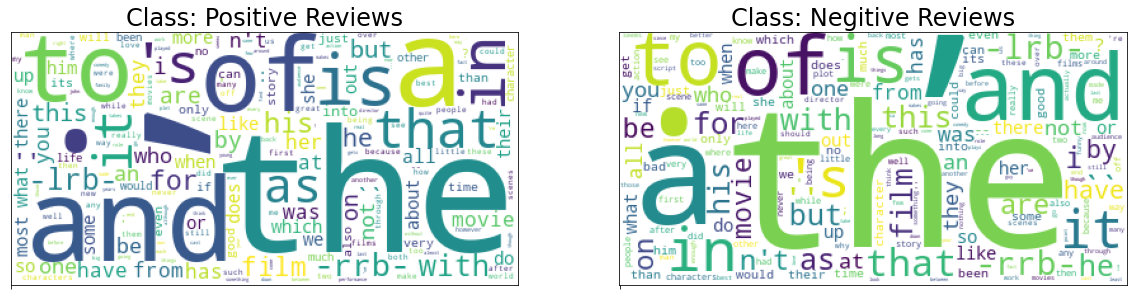

In [366]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {sent.title()}itive Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

### Exclude punctuation

In [334]:
nb_word_freq_punct = nb_word_freq.loc[~nb_word_freq['word'].isin(PUNCTUATION)]
nb_word_freq_punct

,word,POS,NEG
0,norway,0.000003,0.000003
1,illicitly,0.000001,0.000000
2,mothers-in-law,0.000000,0.000002
3,mayberly,0.000000,0.000002
4,mpaa,0.000022,0.000005
...,...,...,...
45338,raccoon,0.000000,0.000003
45339,equation,0.000003,0.000008
45340,propose,0.000000,0.000006
45341,firefighting,0.000000,0.000005


In [335]:
nb_word_freq_punct.sort_values('POS', ascending=False).head(10)

,word,POS,NEG
23977,the,0.051567,0.048530
7021,a,0.025080,0.024699
44953,and,0.024609,0.021672
25706,of,0.023156,0.021414
14689,to,0.020471,0.021364
44662,is,0.017964,0.016160
41658,in,0.014579,0.013940
16465,it,0.010318,0.010841
45056,that,0.010101,0.010820
8038,as,0.008050,0.006835


In [336]:
nb_word_freq_punct.sort_values('NEG', ascending=False).head(10)

,word,POS,NEG
23977,the,0.051567,0.048530
7021,a,0.025080,0.024699
44953,and,0.024609,0.021672
25706,of,0.023156,0.021414
14689,to,0.020471,0.021364
44662,is,0.017964,0.016160
41658,in,0.014579,0.013940
16465,it,0.010318,0.010841
45056,that,0.010101,0.010820
8038,as,0.008050,0.006835


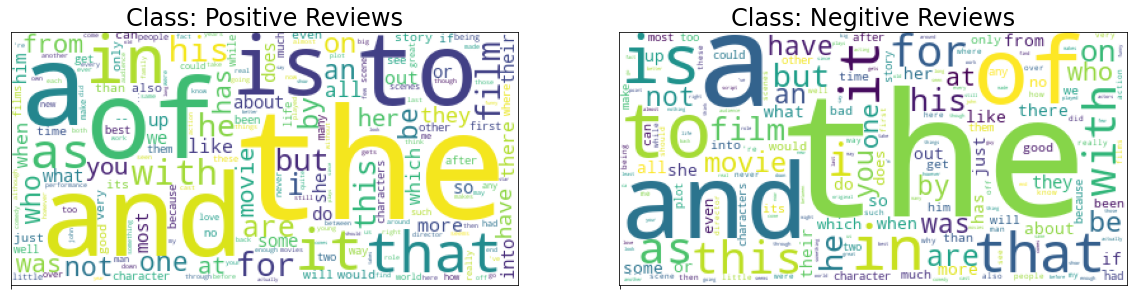

In [367]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_punct.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {sent.title()}itive Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_punct_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [378]:
corpus_punct=MovieReviewCorpus(stemming=False,allowed_vocab=set(nb_word_freq_punct['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [379]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_punct.train)
NB.test(corpus_punct.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_punct.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---


/Users/alanclark/git/MLMI13/Classifiers.py:245: RuntimeWarning: divide by zero encountered in log
  else:


Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [385]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_punct)
# store predictions from classifier
nb_non_smoothed_punct_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47000
Std. Dev: 0.07810


### Exclude stopwords

In [338]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alanclark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [339]:
nb_word_freq_stop = nb_word_freq.loc[~nb_word_freq['word'].isin(stopwords.words('english'))]

In [340]:
nb_word_freq_stop.sort_values('POS', ascending=False).head(10)

,word,POS,NEG
4589,",",0.053313,0.049268
26242,.,0.038389,0.039716
12726,'s,0.011823,0.012108
20306,-rrb-,0.007551,0.008060
36765,-lrb-,0.007526,0.007947
14106,film,0.006496,0.005957
7426,'',0.005541,0.006826
939,``,0.005294,0.006403
35160,one,0.003685,0.003627
36090,n't,0.003411,0.004785


In [341]:
nb_word_freq_stop.sort_values('NEG', ascending=False).head(10)

,word,POS,NEG
4589,",",0.053313,0.049268
26242,.,0.038389,0.039716
12726,'s,0.011823,0.012108
20306,-rrb-,0.007551,0.008060
36765,-lrb-,0.007526,0.007947
7426,'',0.005541,0.006826
939,``,0.005294,0.006403
14106,film,0.006496,0.005957
36090,n't,0.003411,0.004785
42458,movie,0.003108,0.004404


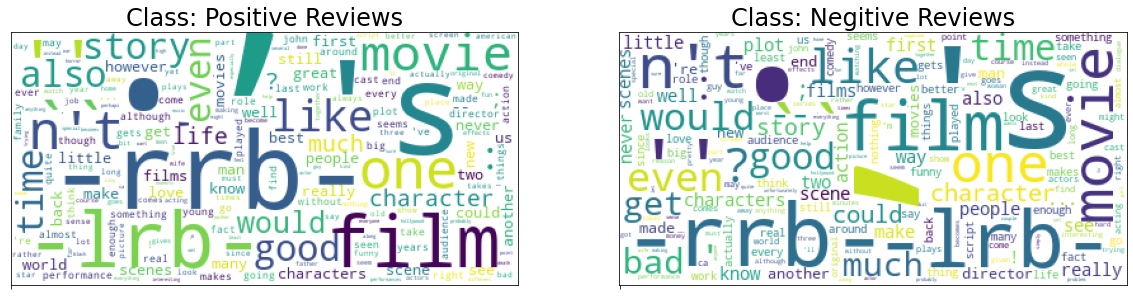

In [368]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_stop.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {sent.title()}itive Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_stop_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [376]:
corpus_stop=MovieReviewCorpus(stemming=False,allowed_vocab=set(nb_word_freq_stop['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [388]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_stop.train)
NB.test(corpus_stop.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_stop.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [389]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_stop)
# store predictions from classifier
nb_non_smoothed_stop_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47000
Std. Dev: 0.07810


### Exclude stopwords and punctuation

In [343]:
nb_word_freq_stop_punct = nb_word_freq.loc[~((nb_word_freq['word'].isin(stopwords.words('english'))) | (nb_word_freq['word'].isin(PUNCTUATION)))]

In [344]:
nb_word_freq_stop_punct.sort_values('POS', ascending=False).head(10)

,word,POS,NEG
14106,film,0.006496,0.005957
35160,one,0.003685,0.003627
42458,movie,0.003108,0.004404
27472,like,0.002161,0.002554
24546,story,0.001537,0.001262
38427,also,0.001500,0.001062
14490,good,0.001484,0.001548
44926,even,0.001456,0.001893
42419,time,0.001449,0.001527
21098,would,0.001343,0.001646


In [345]:
nb_word_freq_stop_punct.sort_values('NEG', ascending=False).head(10)

,word,POS,NEG
14106,film,0.006496,0.005957
42458,movie,0.003108,0.004404
35160,one,0.003685,0.003627
27472,like,0.002161,0.002554
44926,even,0.001456,0.001893
21098,would,0.001343,0.001646
14490,good,0.001484,0.001548
42419,time,0.001449,0.001527
30915,get,0.001108,0.001449
44567,bad,0.000450,0.001438


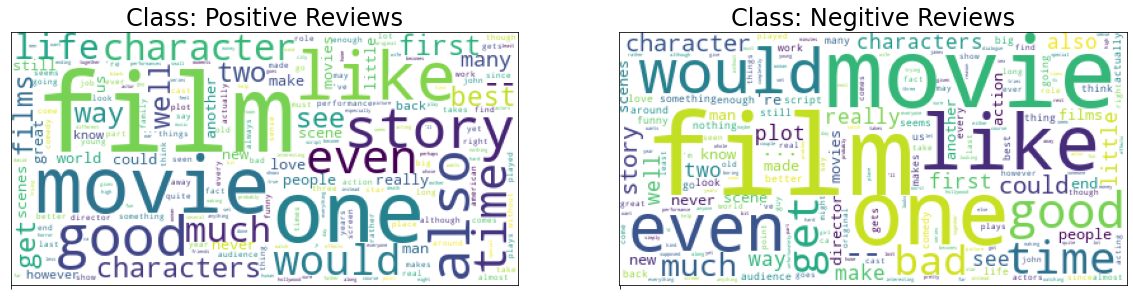

In [369]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate(['POS', 'NEG']):
    nb_word_freq_top = nb_word_freq_stop_punct.sort_values(sent, ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent]].set_index('word').to_dict()[sent]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {sent.title()}itive Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_stop_punct_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [390]:
corpus_stop_punct=MovieReviewCorpus(stemming=False,allowed_vocab=set(nb_word_freq_stop_punct['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [391]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_stop_punct.train)
NB.test(corpus_stop_punct.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_stop_punct.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 1.00000
Number of ties: 0
Test Accuracy without smoothing: 0.47000
Number of ties: 186


In [392]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_stop_punct)
# store predictions from classifier
nb_non_smoothed_stop_punct_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.47000
Std. Dev: 0.07810


### Exclude words not in Lexicon

In [60]:
nb_word_freq_lexicon = lexicon_df.set_index('word').join(nb_word_freq.set_index('word'), how='left').reset_index()
nb_word_freq_lexicon

,word,magnitude,polarity,POS,NEG
0,abandoned,weaksubj,negative,0.000029,0.000030
1,abandonment,weaksubj,negative,0.000003,0.000003
2,abandon,weaksubj,negative,0.000022,0.000012
3,abase,strongsubj,negative,NaN,NaN
4,abasement,strongsubj,negative,NaN,NaN
...,...,...,...,...,...
6881,zealot,strongsubj,negative,0.000001,0.000000
6882,zealous,strongsubj,negative,0.000000,0.000002
6883,zealously,strongsubj,negative,0.000001,0.000002
6884,zenith,strongsubj,positive,0.000001,0.000002


In [62]:
nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == 'positive'].sort_values('POS', ascending=False).head(10)

,word,magnitude,polarity,POS,NEG
3920,like,strongsubj,positive,0.002161,0.002554
3770,just,weaksubj,positive,0.001667,0.002147
6797,will,strongsubj,positive,0.001627,0.001292
2742,good,weaksubj,positive,0.001484,0.001548
2154,even,weaksubj,positive,0.001456,0.001893
6762,well,weaksubj,positive,0.001187,0.000968
614,best,strongsubj,positive,0.001022,0.000693
2777,great,strongsubj,positive,0.000938,0.000527
3969,love,strongsubj,positive,0.000811,0.000612
508,back,weaksubj,positive,0.000695,0.000656


In [63]:
nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == 'negative'].sort_values('NEG', ascending=False).head(10)

,word,magnitude,polarity,POS,NEG
514,bad,strongsubj,negative,0.000450,0.001438
4762,plot,strongsubj,negative,0.000686,0.001178
6222,too,weaksubj,negative,0.000921,0.001143
3934,little,strongsubj,negative,0.000945,0.001018
1851,down,weaksubj,negative,0.000552,0.000600
986,comedy,weaksubj,negative,0.000498,0.000589
3862,least,weaksubj,negative,0.000337,0.000574
3952,long,strongsubj,negative,0.000479,0.000524
6313,trying,weaksubj,negative,0.000319,0.000431
255,although,weaksubj,negative,0.000616,0.000417


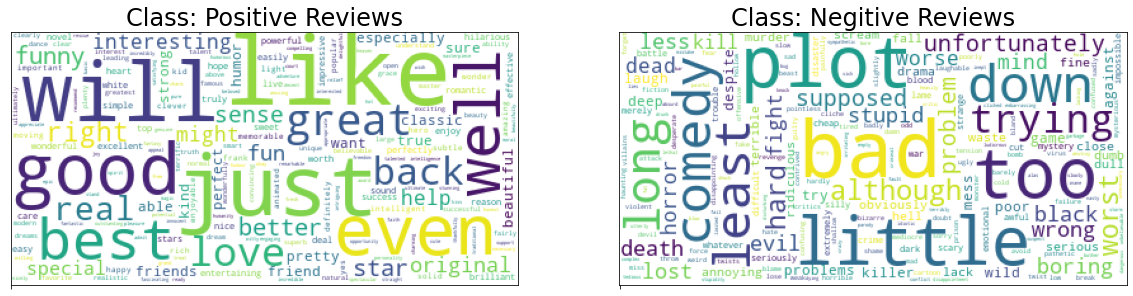

In [370]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, sent in enumerate([('POS', 'positive'), ('NEG', 'negative')]):
    nb_word_freq_top = nb_word_freq_lexicon.loc[nb_word_freq_lexicon['polarity'] == sent[1]].sort_values(sent[0], ascending=False)
    nb_word_freq_top_dict = nb_word_freq_top[['word', sent[0]]].set_index('word').to_dict()[sent[0]]
    wordcloud = WordCloud(background_color='white', collocations=False).generate_from_frequencies(nb_word_freq_top_dict)
    ax[i].imshow(wordcloud)
    ax[i].set_title(f'Class: {sent[0].title()}itive Reviews')
    ax[i].set_xticks([0])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
fig.savefig(os.path.join(plot_dir, 'nb_frequency_lexicon_wordcloud.jpeg'), pad_inches=0.2, bbox_inches='tight')

In [300]:
corpus_lexicon=MovieReviewCorpus(stemming=False,allowed_vocab=set(lexicon_df['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [393]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_lexicon.train)
NB.test(corpus_lexicon.train, verbose=False)
print(f"Training accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")
NB.test(corpus_lexicon.test, verbose=False)
print(f"Test Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Training accuracy without smoothing: 0.96111
Number of ties: 0
Test Accuracy without smoothing: 0.68000
Number of ties: 53


In [394]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_lexicon)
# store predictions from classifier
nb_non_smoothed_lexicon_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.68000
Std. Dev: 0.06000


In [397]:
# see if limiting the vocabulary to the lexicon significantly improves results
p_value=signTest.getSignificance(nb_non_smoothed_preds,nb_non_smoothed_lexicon_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results limiting the vocabulary to the lexicon are {significance} with respect to not doing so")

results limiting the vocabulary to the lexicon are significant with respect to not doing so


### Only allow words that are in the lexicon with positive or negative polarity

In [306]:
corpus_lexicon_pol=MovieReviewCorpus(stemming=False,allowed_vocab=set(lexicon_df.loc[lexicon_df['polarity'].isin(['negative', 'positive'])]['word'].unique()))

Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [351]:
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus_lexicon_pol.train)
NB.test(corpus_lexicon_pol.test, verbose=False)
print(f"Accuracy without smoothing: {NB.getAccuracy():.5f}")
print(f"Number of ties: {NB.ties}")

--- classifying reviews using Naive Bayes on held-out test set ---
Accuracy without smoothing: 0.69500
Number of ties: 47


In [352]:
print("--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus_lexicon_pol)
# store predictions from classifier
nb_non_smoothed_lexicon_pol_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB without smoothing using 10-fold cross-evaluation ---
Accuracy: 0.67500
Std. Dev: 0.08441


## Question 2.0

In [107]:
# use smoothing
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test, verbose=False)
print(f"Accuracy using smoothing: {NB.getAccuracy():.5f}")

Accuracy using smoothing: 0.82500


### Smoothing Grid Search

In [410]:
def nb_extract_frequencies(cond_prod):
    df = pd.DataFrame(cond_prod).reset_index().rename(columns={'level_0': 'word'}).sort_values('word')
    return np.array(df['word']), np.array(df['POS']), np.array(df['NEG'])

In [503]:
nb_laplace_smoothing_vals_large = np.arange(0.2,10,0.2)
nb_laplace_smoothing_test_accuracies = np.zeros_like(nb_laplace_smoothing_vals_large)
for i, laplace_smoothing in tqdm(enumerate(nb_laplace_smoothing_vals_large)):
    NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False,laplacian_k=laplace_smoothing)
    NB.train(corpus.train)
    NB.test(corpus.test, verbose=False)
    words, _, _ = nb_extract_frequencies(NB.condProb)
    nb_laplace_smoothing_test_accuracies[i] = NB.getAccuracy()
nb_laplace_smoothing_test_accuracies

29it [01:27,  2.93s/it]

In [487]:
nb_laplace_smoothing_vals = [0, 0.1, 1, 10]
nb_laplace_smoothing_pos_frequencies = np.zeros((len(nb_laplace_smoothing_vals), 45343))
nb_laplace_smoothing_neg_frequencies = np.zeros((len(nb_laplace_smoothing_vals), 45343))
for i, laplace_smoothing in tqdm(enumerate(nb_laplace_smoothing_vals)):
    NB=NaiveBayesText(smoothing=laplace_smoothing > 0,bigrams=False,trigrams=False,discard_closed_class=False,laplacian_k=laplace_smoothing)
    NB.train(corpus.train)
    NB.test(corpus.test, verbose=False)
    words, pos_freq, neg_freq = nb_extract_frequencies(NB.condProb)

    nb_laplace_smoothing_pos_frequencies[i,:] = pos_freq
    nb_laplace_smoothing_neg_frequencies[i,:] = neg_freq
nb_laplace_smoothing_test_accuracies

0it [00:00, ?it/s]/Users/alanclark/git/MLMI13/Classifiers.py:246: RuntimeWarning: divide by zero encountered in log
  log_word_prob = np.log(word_prob)
4it [00:11,  2.95s/it]


array([0.47 , 0.815, 0.825, 0.75 ])

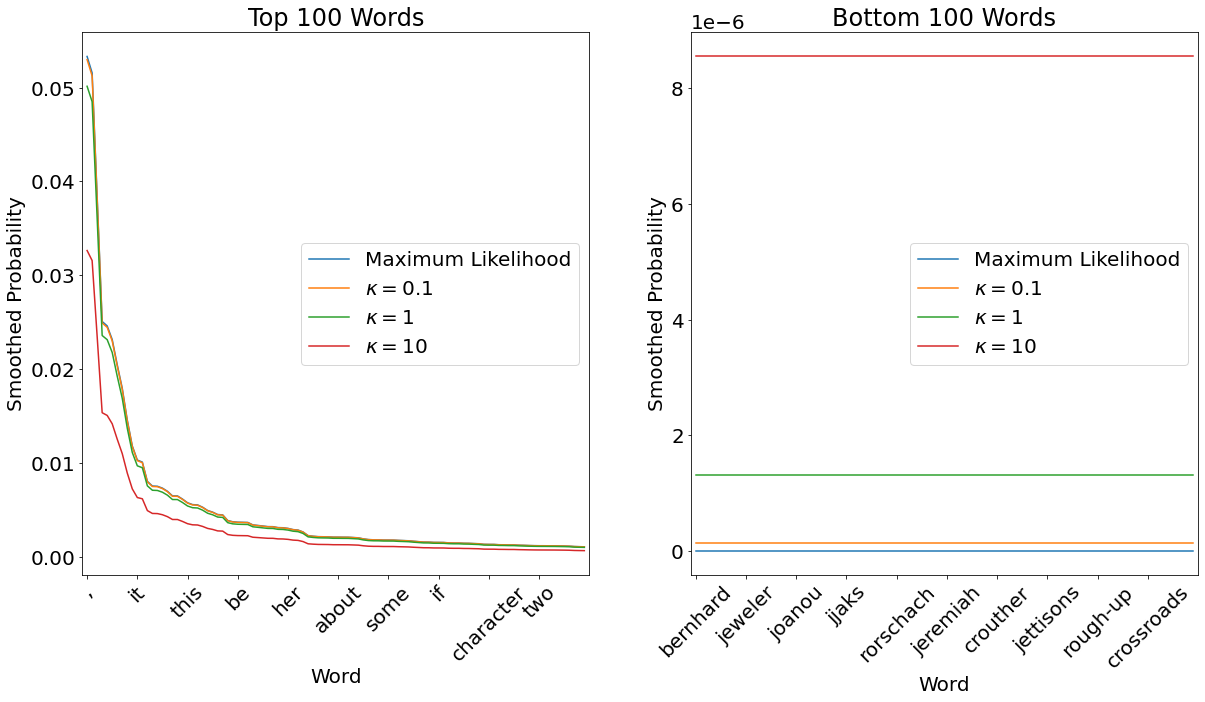

In [500]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

nb_laplace_smoothing_pos_frequencies_argsort = np.argsort(-nb_laplace_smoothing_pos_frequencies[0,:])

ax[0].plot(nb_laplace_smoothing_pos_frequencies[:, nb_laplace_smoothing_pos_frequencies_argsort[:100]].T)
ax[0].set_title("Top 100 Words")
ax[0].set_xlabel("Word")
ax[0].set_ylabel("Smoothed Probability")
ax[0].set_xticks(np.arange(0,100,10))
ax[0].set_xlim(-1,100)
ax[0].set_xticklabels(words[nb_laplace_smoothing_pos_frequencies_argsort[0:100:10]], rotation=45)
ax[0].legend(['Maximum Likelihood', r'$\kappa=0.1$', r'$\kappa=1$', r'$\kappa=10$'], loc='center right')

ax[1].plot(nb_laplace_smoothing_pos_frequencies[:, nb_laplace_smoothing_pos_frequencies_argsort[-100:]].T)
ax[1].set_title("Bottom 100 Words")
ax[1].set_xlabel("Word")
ax[1].set_ylabel("Smoothed Probability")
ax[1].set_xticks(np.arange(0,100,10))
ax[1].set_xlim(-1,100)
ax[1].set_xticklabels(words[nb_laplace_smoothing_pos_frequencies_argsort[-100::10]], rotation=45)
ax[1].legend(['Maximum Likelihood', r'$\kappa=0.1$', r'$\kappa=1$', r'$\kappa=10$'], loc='center right')

ax[2].plot(nb_laplace_smoothing_vals_large, nb_laplace_smoothing_test_accuracies)
ax[2].set_title("Test Accuracy")
ax[2].set_xlabel("Accuracy")
ax[2].set_ylabel(r'Laplace Smoothing Factor, $\kappa$')

fig.savefig(os.path.join(plot_dir, 'nb_smoothed_word_probabilities.jpeg'), pad_inches=0.2, bbox_inches='tight')

## Question 3.0
Moved this part up so that I could use the predictions from cross-evaluation on Q2.1

In [46]:
print("--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus)
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
# using cross-eval for smoothed predictions from now on
smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB and smoothing using 10-fold cross-evaluation ---
Accuracy: 0.81700
Std. Dev: 0.02581


## Question 2.1

In [47]:
# see if smoothing significantly improves results
p_value=signTest.getSignificance(non_smoothed_preds,smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing are {significance} with respect to no smoothing")

results using smoothing are significant with respect to no smoothing


## Question 4.0

In [48]:
print("--- stemming corpus ---")
# retrieve corpus with tokenized text and stemming (using porter)
stemmed_corpus_pickle = "corpus_stem.pkl"
if use_pickles and os.path.isfile(stemmed_corpus_pickle):
    with open(stemmed_corpus_pickle, 'rb') as f:
        stemmed_corpus = pickle.load(f)
else:
    stemmed_corpus=MovieReviewCorpus(stemming=True)
    with open(stemmed_corpus_pickle, 'wb') as f:
        pickle.dump(stemmed_corpus, f)

--- stemming corpus ---
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [49]:
print("--- classifying reviews with NB, smoothing and stemming using 10-fold cross-evaluation ---")
NB.crossValidate(stemmed_corpus)
# saving this for use later
num_stemmed_features=len(NB.vocabulary)
# store predictions from classifier
stemmed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}")
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- classifying reviews with NB, smoothing and stemming using 10-fold cross-evaluation ---
Accuracy: 0.81300
Std. Dev: 0.02193


## Question 4.1

In [50]:
# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(smoothed_preds,stemmed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing are {significance} with respect to no smoothing")

results using smoothing are not significant with respect to no smoothing


## Question 4.2

In [51]:
print("--- determining the number of features before/after stemming ---")
print(f"features before stemming: {num_non_stemmed_features}")
print(f"features after stemming: {num_stemmed_features}")

--- determining the number of features before/after stemming ---
features before stemming: 45343
features after stemming: 32399


## Question 5.0

### Unigrams and bigrams

In [71]:
# use smoothing and unigrams and bigrams
print("--- classifying reviews using Naive Bayes using smoothing with unigrams and bigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test, verbose=False)
print(f"Accuracy using smoothing and bigrams: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with unigrams and bigrams on held-out test set ---
Accuracy using smoothing and bigrams: 0.85000


In [72]:
# cross-validate model using smoothing and unigrams and bigrams
print("--- cross-validating naive bayes using smoothing and unigrams and bigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus)
# saving this for use later
num_bigrams_features=len(NB.vocabulary)
# store predictions from classifier
smoothed_and_bigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and unigrams and bigrams ---
Accuracy: 0.83500
Std. Dev: 0.02439


In [73]:
# see if unigrams and bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_bigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and unigrams and bigrams are {significance} with respect to smoothing only")

results using smoothing and unigrams and bigrams are not significant with respect to smoothing only


### Unigrams, bigrams and trigrams

In [74]:
# use smoothing and unigrams, bigrams and trigrams
print("--- classifying reviews using Naive Bayes using smoothing with unigrams, bigrams and trigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=True,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test, verbose=False)
print(f"Accuracy using smoothing and unigrams, bigrams and trigrams: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with unigrams, bigrams and trigrams on held-out test set ---
Accuracy using smoothing and unigrams, bigrams and trigrams: 0.85000


In [75]:
# cross-validate model using smoothing and bigrams and trigrams
print("--- cross-validating naive bayes using smoothing and bigrams and trigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=True,discard_closed_class=False)
NB.crossValidate(corpus)
# saving this for use later
num_trigrams_features=len(NB.vocabulary)
# store predictions from classifier
smoothed_and_trigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and bigrams and trigrams ---
Accuracy: 0.83600
Std. Dev: 0.02332


In [76]:
# see if unigrams, bigrams and trigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_trigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams and trigrams are {significance} with respect to smoothing only")

results using smoothing and bigrams and trigrams are not significant with respect to smoothing only


In [77]:
# see if unigrams, bigrams and trigrams significantly improves results on unigrams and bigrams NB only
p_value=signTest.getSignificance(smoothed_and_bigram_preds,smoothed_and_trigram_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams and trigrams are {significance} with respect to bigrams only")

results using smoothing and bigrams and trigrams are not significant with respect to bigrams only


### Bigrams only

In [78]:
# use smoothing and bigrams only
print("--- classifying reviews using Naive Bayes using smoothing with bigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=True,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test, verbose=False)
print(f"Accuracy using smoothing and bigrams only: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with bigrams on held-out test set ---
Accuracy using smoothing and bigrams only: 0.86000


In [79]:
# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and bigrams ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus)
# saving this for use later
num_bigrams_only_features=len(NB.vocabulary)
# store predictions from classifier
smoothed_and_bigram_only_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and bigrams ---
Accuracy: 0.84250
Std. Dev: 0.02629


In [80]:
# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_bigram_only_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams are {significance} with respect to smoothing only")

results using smoothing and bigrams are not significant with respect to smoothing only


### Trigrams only

In [81]:
# use smoothing and trigrams only
print("--- classifying reviews using Naive Bayes using smoothing with trigrams on held-out test set ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=False,trigrams=True,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test, verbose=False)
print(f"Accuracy using smoothing and trigrams only: {NB.getAccuracy():.5f}")

--- classifying reviews using Naive Bayes using smoothing with trigrams on held-out test set ---
Accuracy using smoothing and trigrams only: 0.86000


In [82]:
# cross-validate model using smoothing and trigrams
print("--- cross-validating naive bayes using smoothing and trigrams ---")
NB=NaiveBayesText(smoothing=True,unigrams=False,bigrams=False,trigrams=True,discard_closed_class=False)
NB.crossValidate(corpus)
# saving this for use later
num_trigrams_only_features=len(NB.vocabulary)
# store predictions from classifier
smoothed_and_trigram_only_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.5f}") 
print(f"Std. Dev: {NB.getStdDeviation():.5f}")

--- cross-validating naive bayes using smoothing and trigrams ---
Accuracy: 0.84600
Std. Dev: 0.01300


In [83]:
# see if trigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_trigram_only_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and trigrams are {significance} with respect to smoothing only")

results using smoothing and trigrams are not significant with respect to smoothing only


## Question 5.1

In [84]:
print(f"features with unigrams and bigrams: {num_bigrams_features}")
print(f"features with unigrams, bigrams and trigrams: {num_trigrams_features}")
print(f"features with bigrams: {num_bigrams_only_features}")
print(f"features with trigrams: {num_trigrams_only_features}")

features with unigrams and bigrams: 471696
features with unigrams, bigrams and trigrams: 1420387
features with bigrams: 426353
features with trigrams: 948691


# SVM

## Question 6 and 6.1

In [85]:
print("--- classifying reviews using SVM on held-out test set ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.train(corpus.train)
SVM.test(corpus.test)
print(f"Accuracy with SVM using unigrams: {SVM.getAccuracy():.5f}")

--- classifying reviews using SVM on held-out test set ---
Accuracy with SVM using unigrams: 0.85500


In [87]:
print("--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.crossValidate(corpus)
# store predictions from classifier
svm_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using SVM with unigrams and 10-fold cross-eval ---
Accuracy: 0.83100
Std. Dev: 0.01319


In [88]:
# see if SVM significantly improves results on smoothed NB
p_value=signTest.getSignificance(smoothed_preds,svm_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using SVM {significance} with respect to smoothed NB")

results using SVM not significant with respect to smoothed NB


In [86]:
SVM=SVMText(bigrams=True,trigrams=False,discard_closed_class=False)
SVM.train(corpus.train)
SVM.test(corpus.test)
print(f"Accuracy with SVM using additional bigrams: {SVM.getAccuracy():.5f}")

Accuracy with SVM using additional bigrams: 0.86000


In [89]:
SVM=SVMText(bigrams=True,trigrams=True,discard_closed_class=False)
SVM.train(corpus.train)
SVM.test(corpus.test)
print(f"Accuracy with SVM using additional bigrams and trigrams: {SVM.getAccuracy():.5f}")

Accuracy with SVM using additional bigrams and trigrams: 0.84000


# POS

## Question 7

In [90]:
print("--- adding in POS information to corpus ---")

--- adding in POS information to corpus ---


In [91]:
print("--- pos corpus ---")
# retrieve corpus with tokenized text and pos
pos_corpus_pickle = "corpus_pos.pkl"
if use_pickles and os.path.isfile(pos_corpus_pickle):
    with open(pos_corpus_pickle, 'rb') as f:
        pos_corpus = pickle.load(f)
else:
    pos_corpus=MovieReviewCorpus(pos=True)
    with open(pos_corpus_pickle, 'wb') as f:
        pickle.dump(pos_corpus, f)

--- pos corpus ---
Identified 1000 POS files to be processed
Identified 1000 NEG files to be processed
Processing POS files
Processing NEG files


In [92]:
print("--- training nb on word+pos features ----")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(pos_corpus.train)
NB.test(pos_corpus.test, verbose=False)
print(f"Accuracy using NB on unigrams without smoothing and with POS: {NB.getAccuracy():.5f}")

--- training nb on word+pos features ----


/Users/alanclark/git/MLMI13/Classifiers.py:218: RuntimeWarning: divide by zero encountered in log
  else:


Accuracy using NB on unigrams without smoothing and with POS: 0.51000


In [93]:
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(pos_corpus.train)
NB.test(pos_corpus.test, verbose=False)
print(f"Accuracy using NB on unigrams with smoothing and POS: {NB.getAccuracy():.5f}")

Accuracy using NB on unigrams with smoothing and POS: 0.83000


In [94]:
print("--- training svm on word+pos features ----")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.train(pos_corpus.train)
SVM.test(pos_corpus.test)
print(f"Accuracy with SVM with POS: {SVM.getAccuracy():.5f}")

--- training svm on word+pos features ----
Accuracy with SVM with POS: 0.84500


In [96]:
print("--- classifying reviews using svm on word+pos and 10-fold cross-eval ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.crossValidate(corpus)
# store predictions from classifier
svm_pos_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using svm on word+pos and 10-fold cross-eval ---
Accuracy: 0.83100
Std. Dev: 0.01319


In [97]:
# see if POS significantly improves results on SVM only
p_value=signTest.getSignificance(svm_preds,svm_pos_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using POS tags {significance} with respect to SVM")

results using POS tags not significant with respect to SVM


# Discard Closed Class

In [98]:
print("--- training nb discarding closed-class words ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=True)
NB.train(pos_corpus.train)
NB.test(pos_corpus.test, verbose=False)
print(f"Accuracy using NB without smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")

--- training nb discarding closed-class words ---


/Users/alanclark/git/MLMI13/Classifiers.py:218: RuntimeWarning: divide by zero encountered in log
  else:


Accuracy using NB without smoothing and discarding closed-class words: 0.51000


In [99]:
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=True)
NB.train(pos_corpus.train)
NB.test(pos_corpus.test, verbose=False)
print(f"Accuracy using NB with smoothing and discarding closed-class words: {NB.getAccuracy():.5f}")

Accuracy using NB with smoothing and discarding closed-class words: 0.83000


In [100]:
print("--- training svm discarding closed-class words ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=True)
SVM.train(pos_corpus.train)
SVM.test(pos_corpus.test)
print(f"Accuracy with SVM discarding closed-class word: {SVM.getAccuracy():.5f}")

--- training svm discarding closed-class words ---
Accuracy with SVM discarding closed-class word: 0.84000


In [101]:
print("--- classifying reviews using svm discarding closed-class words and 10-fold cross-eval ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=True)
SVM.crossValidate(pos_corpus)
# store predictions from classifier
svm_closed_class=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.5f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.5f}")

--- classifying reviews using svm discarding closed-class words and 10-fold cross-eval ---
Accuracy: 0.83050
Std. Dev: 0.01809


In [102]:
# see if discarding closed-class words significantly improves results on SVM only
p_value=signTest.getSignificance(svm_preds,svm_closed_class)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results discardig closed-class words {significance} with respect to SVM")

results discardig closed-class words not significant with respect to SVM


## Question 8.0

In [ ]:
# print("--- using document embeddings ---")